In [ ]:
# Ignore InterpolationMode warnings from torchmeta
import warnings

warnings.filterwarnings("ignore")

In [ ]:
pip install torchmeta

In [ ]:
import os

import easydict
import matplotlib.pyplot as plt

# torch <= 1.9.1
import torch
import torch.nn as nn
import torch.nn.functional as F

# In Colab, install torchmeta using 'pip install torchmeta'
from torchmeta.datasets.helpers import omniglot
from torchmeta.utils.data import BatchMetaDataLoader
from tqdm import tqdm

In [ ]:
def get_dataloader(args):
    train_dataset = omniglot(
        args.folder,
        shots=args.num_shots,
        # test_shots=1, # default = shots
        ways=args.num_ways,
        shuffle=True,
        meta_train=True,
        download=args.download,
    )
    train_dataloader = BatchMetaDataLoader(
        train_dataset, batch_size=args.task_batch_size, shuffle=True, num_workers=1
    )

    test_dataset = omniglot(
        args.folder,
        shots=args.num_shots,
        # test_shots=1, # default = shots
        ways=args.num_ways,
        shuffle=True,
        meta_test=True,
        download=args.download,
    )
    test_dataloader = BatchMetaDataLoader(
        test_dataset, batch_size=args.task_batch_size, shuffle=True, num_workers=1
    )

    val_dataset = omniglot(
        args.folder,
        shots=args.num_shots,
        # test_shots=1, # default = shots
        ways=args.num_ways,
        shuffle=True,
        meta_val=True,
        download=args.download,
    )
    val_dataloader = BatchMetaDataLoader(
        val_dataset, batch_size=args.task_batch_size, shuffle=True, num_workers=1
    )

    return train_dataloader, test_dataloader, val_dataloader

In [ ]:
def save_model(args, model, title):
    if not os.path.isdir(args.output_folder):
        os.mkdir(args.output_folder)
    filename = os.path.join(args.output_folder, title)
    with open(filename, "wb") as f:
        state_dict = model.state_dict()
        torch.save(state_dict, f)
    print("model saved in", filename)


def load_model(args, model, title):
    print("Load model")
    filename = os.path.join(args.output_folder, title)
    model.load_state_dict(torch.load(filename))

In [ ]:
def print_graph(train_accuracies, val_accuracies, train_losses, val_losses):
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    axs[0].plot(train_accuracies, label="train_acc")
    axs[0].plot(val_accuracies, label="test_acc")
    axs[0].set_title("Accuracy")
    axs[0].legend()

    axs[1].plot(train_losses, label="train_loss")
    axs[1].plot(val_losses, label="test_loss")
    axs[1].set_title("Loss")
    axs[1].legend()

    fig.show()

In [ ]:
class PrototypicalNet(nn.Module):
    def __init__(self, in_channels, num_ways, num_shots):
        super(PrototypicalNet, self).__init__()
        self.in_channels = in_channels
        self.emb_size = 64
        self.num_ways = num_ways
        self.num_support = num_ways * num_shots
        self.num_query = self.num_support

        self.embedding_net = nn.Sequential(
            self.convBlock(self.in_channels, self.emb_size, 3),  # 14
            self.convBlock(self.emb_size, self.emb_size, 3),  # 7
            self.convBlock(self.emb_size, self.emb_size, 3),  # 3
            self.convBlock(self.emb_size, self.emb_size, 3),  # 1
            nn.Flatten(start_dim=1),
            nn.Linear(self.emb_size, self.emb_size),
        )

    def convBlock(self, in_channels, out_channels, kernel_size, **kwargs):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, padding=1, **kwargs),
            nn.BatchNorm2d(out_channels, momentum=1.0, track_running_stats=False),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

    def get_prototypes(self, embeddings, targets):
        batch_size = embeddings.shape[0]
        indices = targets.unsqueeze(-1).expand_as(embeddings)

        prototypes = embeddings.new_zeros((batch_size, self.num_ways, self.emb_size))
        prototypes.scatter_add_(1, indices, embeddings).div_(float(self.num_support) / self.num_ways)
        return prototypes

    def forward(self, support_x, support_y, query_x):
        batch_size = support_x.shape[0]
        support_emb = self.embedding_net(support_x.flatten(start_dim=0, end_dim=1)).unflatten(
            dim=0, sizes=[batch_size, self.num_support]
        )
        query_emb = self.embedding_net(query_x.flatten(start_dim=0, end_dim=1)).unflatten(
            dim=0, sizes=[batch_size, self.num_query]
        )
        proto_emb = self.get_prototypes(support_emb, support_y)
        distance = torch.sum((query_emb.unsqueeze(2) - proto_emb.unsqueeze(1)) ** 2, dim=-1)
        return proto_emb, support_emb, query_emb, distance

In [ ]:
def train_proto(args, task_batch, model, criterion, optimizer):
    model.train()

    support_xs = task_batch["train"][0].to(device=args.device)
    support_ys = task_batch["train"][1].to(device=args.device)
    query_xs = task_batch["test"][0].to(device=args.device)
    query_ys = task_batch["test"][1].to(device=args.device)

    accuracy = torch.tensor(0.0, device=args.device)

    proto_emb, support_emb, query_emb, distance = model(support_xs, support_ys, query_xs)
    distance_flat = distance.flatten(start_dim=0, end_dim=1)
    query_ys_flat = query_ys.flatten()
    loss = criterion(-distance_flat, query_ys_flat)

    model.zero_grad()
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        _, query_pred = torch.min(distance, dim=-1)
        accuracy += torch.mean(query_pred.eq(query_ys).float())

    return accuracy.item(), loss.item()

In [ ]:
def test_proto(args, task_batch, model, criterion, optimizer):
    model.eval()

    support_xs = task_batch["train"][0].to(device=args.device)
    support_ys = task_batch["train"][1].to(device=args.device)
    query_xs = task_batch["test"][0].to(device=args.device)
    query_ys = task_batch["test"][1].to(device=args.device)

    accuracy = torch.tensor(0.0, device=args.device)

    proto_emb, support_emb, query_emb, distance = model(support_xs, support_ys, query_xs)
    distance_flat = distance.flatten(start_dim=0, end_dim=1)
    query_ys_flat = query_ys.flatten()
    loss = criterion(-distance_flat, query_ys_flat)

    with torch.no_grad():
        _, query_pred = torch.min(distance, dim=-1)
        accuracy += torch.mean(query_pred.eq(query_ys).float())

    return accuracy.item(), loss.item()

In [ ]:
args = easydict.EasyDict(
    {
        "folder": "dataset",
        "download": True,
        "num_shots": 5,
        "num_ways": 5,
        "output_folder": "model",
        "task_batch_size": 32,  # 필수
        "num_task_batch_train": 600,  # 필수
        "num_task_batch_test": 200,  # 필수
        "device": "cuda",  # 필수
    }
)

train_dataloader, test_dataloader, val_dataloader = get_dataloader(args)
model = PrototypicalNet(1, args.num_ways, args.num_shots).to(device=args.device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

100%|██████████| 600/600 [09:58<00:00,  1.00it/s, train_accuracy=0.9875, train_loss=0.0353, val_accuracy=0.9825, val_loss=0.0531]


model saved in model/prototypical_network.th


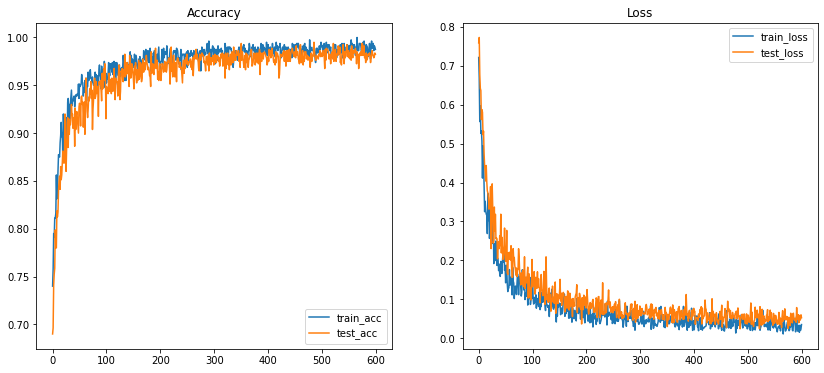

In [ ]:
# Training loop
with tqdm(zip(train_dataloader, val_dataloader), total=args.num_task_batch_train) as pbar:
    train_accuracies = []
    val_accuracies = []
    train_losses = []
    val_losses = []

    for task_batch_idx, (train_batch, val_batch) in enumerate(pbar):
        if task_batch_idx >= args.num_task_batch_train:
            break

        train_accuracy, train_loss = train_proto(args, train_batch, model, criterion, optimizer)
        val_accuracy, val_loss = test_proto(args, val_batch, model, criterion, optimizer)

        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        pbar.set_postfix(
            train_accuracy="{0:.4f}".format(train_accuracy),
            val_accuracy="{0:.4f}".format(val_accuracy),
            train_loss="{0:.4f}".format(train_loss),
            val_loss="{0:.4f}".format(val_loss),
        )

    # save model
    save_model(args, model, "prototypical_network.th")
    print_graph(train_accuracies, val_accuracies, train_losses, val_losses)

In [ ]:
# load model
load_model(args, model, "prototypical_network.th")

# Testing loop
with tqdm(test_dataloader, total=args.num_task_batch_test) as pbar:
    sum_test_accuracies = 0.0
    sum_test_losses = 0.0

    for task_batch_idx, test_batch in enumerate(pbar):
        if task_batch_idx >= args.num_task_batch_test:
            break

        test_accuracy, test_loss = test_proto(args, test_batch, model, criterion, optimizer)

        sum_test_accuracies += test_accuracy
        sum_test_losses += test_loss
        pbar.set_postfix(
            test_accuracy="{0:.4f}".format(sum_test_accuracies / (task_batch_idx + 1)),
            test_loss="{0:.4f}".format(sum_test_losses / (task_batch_idx + 1)),
        )

Load model


100%|██████████| 200/200 [02:20<00:00,  1.42it/s, test_accuracy=0.9806, test_loss=0.0591]
